<a href="https://colab.research.google.com/github/smaranjitghose/Big_Cat_Classifier/blob/master/notebooks/Big_Cat_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Cat Classifier 🐯

An image classifier built using Vision Transformers that categories images of the big cats into the following classes:

1. Cheetah
2. Jaguar
3. Leopard
4. Lion
5. Tiger

__Reference__: [Hugging Pics](https://github.com/nateraw/huggingpics)

In [1]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs

     |████████████████████████████████| 2.5MB 8.2MB/s 
     |████████████████████████████████| 819kB 44.3MB/s 
     |████████████████████████████████| 901kB 50.7MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 
     |████████████████████████████████| 122kB 56.6MB/s 
     |████████████████████████████████| 235kB 50.0MB/s 
     |████████████████████████████████| 829kB 47.6MB/s 
     |████████████████████████████████| 10.6MB 42.7MB/s 
     |████████████████████████████████| 1.3MB 41.2MB/s 
     |████████████████████████████████| 143kB 51.9MB/s 
     |████████████████████████████████| 296kB 53.4MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: pytorch-lightning 1.3.8 has requirement PyYAML<=5.4.1,>=5.1, but you'll have pyyaml 3.13 which is incompatible.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archiv

In [2]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [4]:
class_labels = ["cheetah", "jaguar","leopard", "lion", "tiger"]

Get Images From The Web

In [8]:
SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
  """
  Method to save the images generated from the URLs in the respective directories
  """
  for i, image in enumerate(gen_images_from_urls(urls)):
      image.save(save_directory / f'{i}.jpg')

In [9]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir) # Remove any previous instance of images folder for the dataset

for class_label in class_labels:
    class_label_dir = data_dir / class_label # Path for the particular class label directory
    class_label_dir.mkdir(exist_ok=True, parents=True) # Make the particular class label directory while creating any parent directories if they don't exist and ignore if already exists
    urls = get_image_urls_by_term(class_label) # Populate a list of URLs of the images found belonging to the particular class label
    print(f"Saving images of {class_label} to {str(class_label_dir)}...")
    urls_to_image_folder(urls, class_label_dir)

Saving images of cheetah to images/cheetah...
Retrieved 150 images. Skipped 0.
Saving images of jaguar to images/jaguar...
Retrieved 150 images. Skipped 0.
Saving images of leopard to images/leopard...
Retrieved 150 images. Skipped 0.
Saving images of lion to images/lion...
Retrieved 150 images. Skipped 0.
Saving images of tiger to images/tiger...
Retrieved 150 images. Skipped 0.


## Init Dataset and Split into Training and Validation Sets


In [10]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

Viewing some images from our dataset

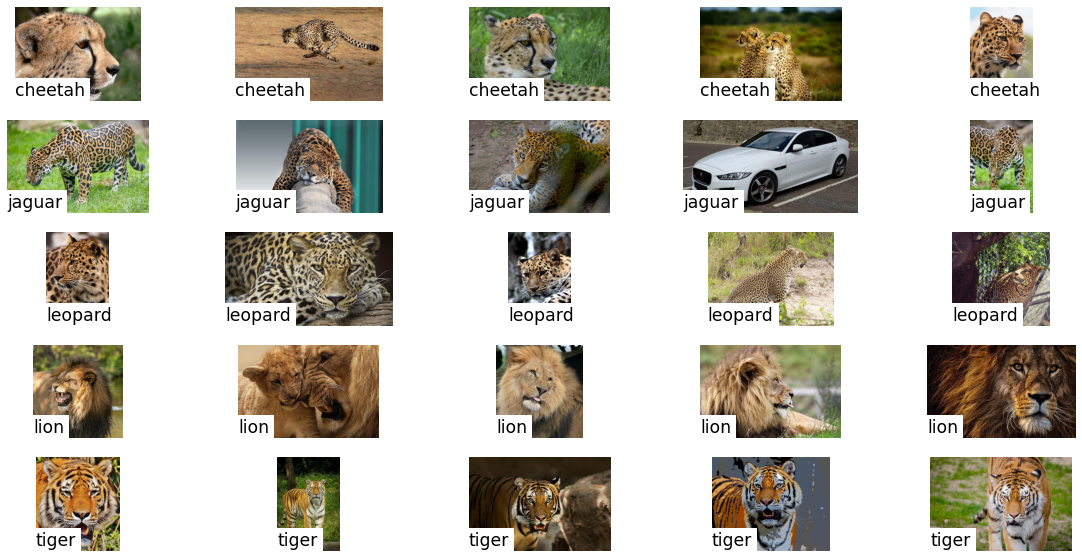

In [11]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

 Preparing Labels for Our Model's Config


In [12]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [13]:
print(label2id)

{'cheetah': '0', 'jaguar': '1', 'leopard': '2', 'lion': '3', 'tiger': '4'}


In [14]:
print(id2label)

{'0': 'cheetah', '1': 'jaguar', '2': 'leopard', '3': 'lion', '4': 'tiger'}


#### Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [15]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

### Init Feature Extractor, Model, Data Loaders


In [16]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training



In [17]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

In [18]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=10)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.210   Total estimated model params size (MB)


Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


#### Check if it Worked 😅

In [19]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([4, 4, 2, 3, 2, 4, 0, 2])
Labels: tensor([4, 4, 2, 3, 2, 4, 0, 0])
